# **Restricted Boltzmann Machine(RBM) on MINIST dataset**

## Load the MINIST dataset :

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

BATCHSIZE = 16
VISIBLE_UNITS = 28*28
HIDDEN_UNITS = 128
CD_K = 1
EPOCHS = 10

# load datasets
tr_dataset = datasets.MNIST('data/mnist', train=True, transform=transforms.ToTensor(), download=True)
tr_loader = torch.utils.data.DataLoader(tr_dataset, batch_size=BATCHSIZE)

ts_dataset = datasets.MNIST('data/mnist', train=False, transform=transforms.ToTensor(), download=True)
ts_loader = torch.utils.data.DataLoader(ts_dataset, batch_size=BATCHSIZE)

## Define RBM model

In [2]:
class RBM():
  def __init__(self, n_visible, n_hidden, k, lr=1e-3, momentum_rate=0.5, w_decay=1e-4):
    self.n_visible = n_visible
    self.n_hidden = n_hidden
    self.k = k
    self.lr = lr
    self.momentum_rate = momentum_rate
    self.w_decay = w_decay
  
    self.w = torch.randn(n_visible, n_hidden) * 0.1
    #self.w = torch.normal(0, 0.01, size = (n_visible, n_hidden))
    self.visible_b = torch.ones(n_visible) * 0.5
    self.hidden_b = torch.zeros(n_hidden)

    self.w_momentum = torch.zeros(n_visible, n_hidden)
    self.visible_b_momentum = torch.zeros(n_visible)
    self.hidden_b_momentum = torch.zeros(n_hidden)
    self.linear = torch.nn.Linear(784, 10)

  def _sample(self, p, size):
    return (p >= torch.rand(size)).float()

  def v2h(self, visible_p):
    hidden_activations = torch.matmul(visible_p, self.w) + self.hidden_b
    hidden_p = 1 / (1 + torch.exp(-hidden_activations))
    return hidden_p, self._sample(hidden_p, self.n_hidden)

  def h2v(self, hidden_p):
    visible_activations = torch.matmul(hidden_p, self.w.t()) + self.visible_b
    visible_p = 1 / (1 + torch.exp(-visible_activations))
    return visible_p

  def cd(self, input):
    # wake part
    pos_hidden_p, pos_hidden = self.v2h(input)
    wake = torch.matmul(input.t(), pos_hidden_p)

    # dream part
    neg_hidden_p = pos_hidden_p
    for step in range(self.k):
      recon_visible_p = self.h2v(neg_hidden_p)
      neg_hidden_p, neg_hidden = self.v2h(recon_visible_p)
    
    dream = torch.matmul(recon_visible_p.t(), neg_hidden_p)
    Delta_w = wake - dream

    #update parameters
    self.w_momentum = self.momentum_rate*(self.w_momentum) + Delta_w
    self.visible_b_momentum = self.momentum_rate*(self.visible_b_momentum) + torch.sum(input - recon_visible_p, dim=0)
    self.hidden_b_momentum = self.momentum_rate*(self.hidden_b_momentum) + torch.sum(pos_hidden_p - neg_hidden_p, dim=0)


    batch_size = input.size(0)
    self.w += self.w_momentum * self.lr / batch_size
    self.visible_b += self.visible_b_momentum * self.lr / batch_size
    self.hidden_b += self.hidden_b_momentum * self.lr / batch_size

    self.w -= self.w * self.w_decay
    #reconstruciton error
    err = torch.sum((input - recon_visible_p)**2)

    return err, input, recon_visible_p, self._sample(recon_visible_p, self.n_visible)

  def softmax(self, input):
    outputs = self.linear(input)
    
    return F.log_softmax(x, dim=1)


## Train RBM model

In [3]:
# training RBM
rbm = RBM(VISIBLE_UNITS, HIDDEN_UNITS, CD_K)

for epoch in range(EPOCHS):
  epoch_err = 0.0

  for batch, _ in tr_loader:
    batch = batch.view(len(batch), VISIBLE_UNITS)
    batch_err, data, recon_data_p, recon_data = rbm.cd(batch)
    epoch_err += batch_err

  print("Epoch Error (epoch=%d): %.4f" % (epoch, epoch_err))

Epoch Error (epoch=0): 2614099.7500
Epoch Error (epoch=1): 1596829.1250
Epoch Error (epoch=2): 1464269.2500
Epoch Error (epoch=3): 1396071.5000
Epoch Error (epoch=4): 1351676.8750
Epoch Error (epoch=5): 1320085.6250
Epoch Error (epoch=6): 1296232.1250
Epoch Error (epoch=7): 1277312.8750
Epoch Error (epoch=8): 1261751.8750
Epoch Error (epoch=9): 1248608.7500


## Define a classification model by placing a softmax layer after the RBM

In [4]:
class myNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(myNet, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x, _ = rbm.v2h(x)
        outputs = self.linear(x)

        return F.log_softmax(outputs, dim=1)

In [5]:
myModel = myNet(HIDDEN_UNITS, 10)

### Train the classifier :

In [6]:
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(myModel.parameters(), lr=1e-3)

In [7]:
from torch.autograd import Variable

for epoch in range(10):
  for i, (batch, labels) in enumerate(tr_loader):
    batch = Variable(batch.view(-1, VISIBLE_UNITS))
    labels = Variable(labels)

    optimizer.zero_grad()
    outputs = myModel(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # calculate Accuracy
  correct = 0
  total = 0
  y_true = []
  y_pred = []
  for batch, labels in ts_loader:
    batch = Variable(batch.view(-1, VISIBLE_UNITS))
    outputs = myModel(batch)
    _, prediction = torch.max(outputs.data, 1)
    y_true.extend(labels)
    y_pred.extend(prediction)
    total += labels.size(0)
    # for gpu, bring the predicted and labels back to cpu fro python operations to work
    correct+= (prediction == labels).sum()
    accuracy = 100 * correct/total
  print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch+1, loss.item(), accuracy))

Epoch: 1. Loss: 0.10645102709531784. Accuracy: 89.55999755859375.
Epoch: 2. Loss: 0.07151033729314804. Accuracy: 90.6500015258789.
Epoch: 3. Loss: 0.06119031086564064. Accuracy: 91.08999633789062.
Epoch: 4. Loss: 0.05642744153738022. Accuracy: 91.47000122070312.
Epoch: 5. Loss: 0.05374572053551674. Accuracy: 91.76000213623047.
Epoch: 6. Loss: 0.052041903138160706. Accuracy: 92.08999633789062.
Epoch: 7. Loss: 0.050865963101387024. Accuracy: 92.30000305175781.
Epoch: 8. Loss: 0.05000566318631172. Accuracy: 92.5.
Epoch: 9. Loss: 0.049349091947078705. Accuracy: 92.69000244140625.
Epoch: 10. Loss: 0.04883194714784622. Accuracy: 92.83000183105469.


### Build the confusion matrix :

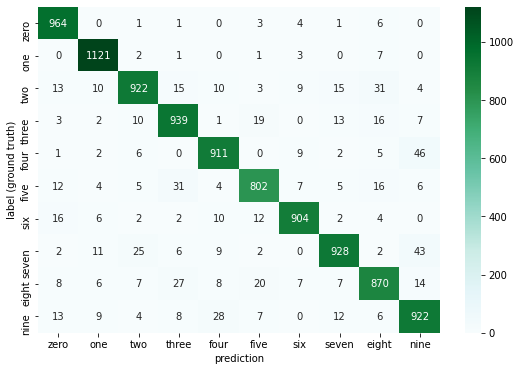

In [8]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Display the confusion matrix as a heatmap
arr = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four',
        'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

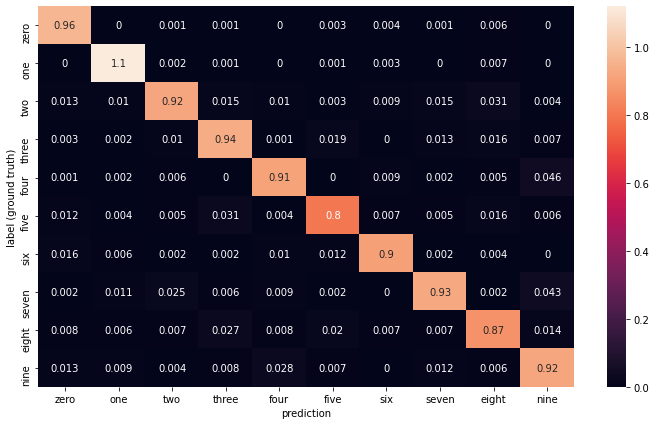

In [9]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four',
        'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

## Define a classification model taking the RBM hidden states as embbedings.

In [10]:
class NewNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NewNet, self).__init__()
        self.fl1 = torch.nn.Linear(input_dim, HIDDEN_UNITS)
        # with torch.no_grad():
        #   self.fl1.weight.data.copy_(torch.transpose(rbm.w, 0, 1))
        #   self.fl1.bias.data.copy_(rbm.hidden_b)
        self.fl2 = torch.nn.Linear(HIDDEN_UNITS, output_dim)

    def forward(self, x):
        x = self.fl1(x)
        x = F.sigmoid(x)
        x = self.fl2(x)

        return F.log_softmax(x, dim=1)

In [11]:
Newmodel = NewNet(VISIBLE_UNITS, 10)

In [12]:
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(Newmodel.parameters(), lr=1e-3)

### Train the classifier :

In [13]:
from torch.autograd import Variable

for epoch in range(10):
  for i, (batch, labels) in enumerate(tr_loader):
    batch = Variable(batch.view(-1, VISIBLE_UNITS))
    labels = Variable(labels)

    optimizer.zero_grad()
    outputs = Newmodel(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # calculate Accuracy
  correct = 0
  total = 0
  y_true = []
  y_pred = []
  for batch, labels in ts_loader:
    batch = Variable(batch.view(-1, VISIBLE_UNITS))
    outputs = Newmodel(batch)
    _, prediction = torch.max(outputs.data, 1)
    y_true.extend(labels)
    y_pred.extend(prediction)
    total += labels.size(0)
    # for gpu, bring the predicted and labels back to cpu fro python operations to work
    correct += (prediction == labels).sum()
    accuracy = 100 * correct/total
  print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch+1, loss.item(), accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1. Loss: 0.018700823187828064. Accuracy: 93.87000274658203.
Epoch: 2. Loss: 0.009582671336829662. Accuracy: 95.87999725341797.
Epoch: 3. Loss: 0.006320953834801912. Accuracy: 96.7699966430664.
Epoch: 4. Loss: 0.0039049608167260885. Accuracy: 97.16999816894531.
Epoch: 5. Loss: 0.0023373838048428297. Accuracy: 97.30999755859375.
Epoch: 6. Loss: 0.0013919728808104992. Accuracy: 97.4000015258789.
Epoch: 7. Loss: 0.0008731582202017307. Accuracy: 97.55000305175781.
Epoch: 8. Loss: 0.0006000933353789151. Accuracy: 97.5199966430664.
Epoch: 9. Loss: 0.00043818075209856033. Accuracy: 97.5.
Epoch: 10. Loss: 0.0003224652027711272. Accuracy: 97.48999786376953.


### Build the confusion matrix :

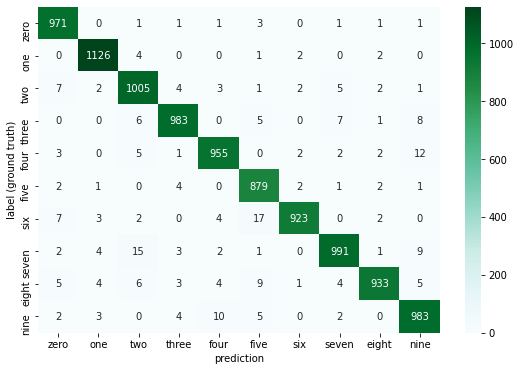

In [14]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Display the confusion matrix as a heatmap
arr = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four',
        'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

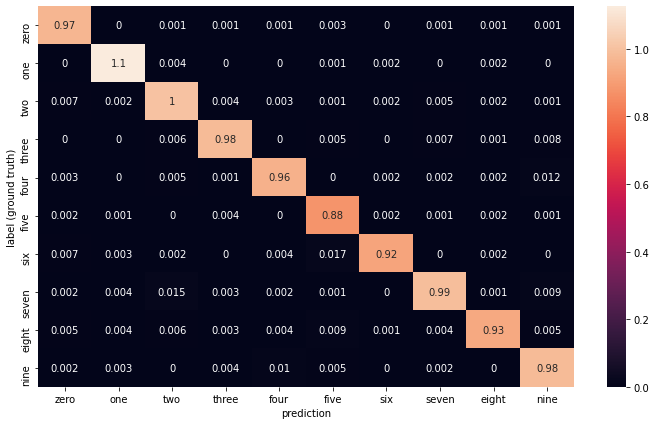

In [15]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four',
        'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

## Plot the results

In [16]:
from torchvision.utils import make_grid , save_image

def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

### plot raw last batch:

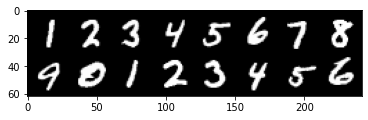

In [17]:
show_adn_save("real",make_grid(batch.view(data.shape[0],1,28,28).data))

### plot reconstructed last batch with propbalitys :

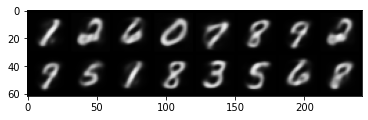

In [18]:
show_adn_save("generate",make_grid(recon_data_p.view(recon_data_p.shape[0],1,28,28).data))

### plot reconstructed last batch with sampled data :

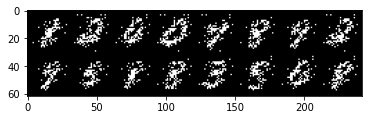

In [19]:
show_adn_save("generate",make_grid(recon_data.view(recon_data.shape[0],1,28,28).data))

### plot single image from the batch:

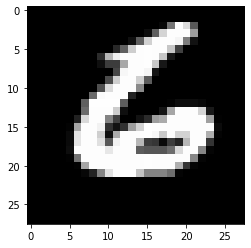

In [20]:
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

show_adn_save("real",make_grid(batch[-1].view(1,28,28).data))

### plot the reconstruced first batch of test dataset :

In [21]:
examples = enumerate(ts_loader)
batch_idx, (example_data, example_targets) = next(examples)

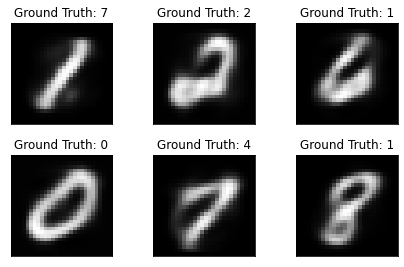

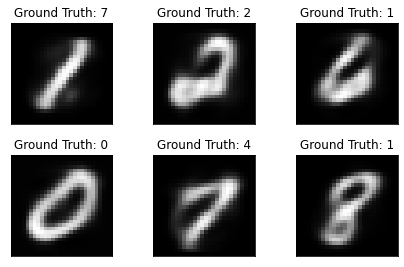

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(recon_data_p.view(recon_data_p.shape[0],1,28,28)[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Try to apply affine transformation to the raw img, in result the classifier will make a wrong prediction on the new img: 

Text(0.5, 1.0, 'Ground Truth: 7')

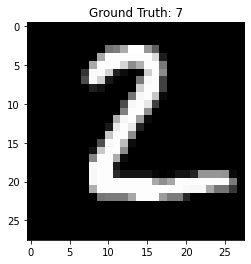

In [23]:
plt.imshow(example_data[1][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[0]))

Text(0.5, 1.0, 'Ground Truth: 7')

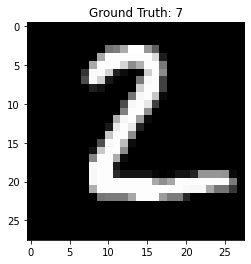

In [24]:
plt.imshow(example_data[1][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[0]))

### Define a composed transforms :

In [25]:
compose = transforms.Compose([transforms.RandomAffine(10, translate = (0.02,0.09)),transforms.Resize((28,28))])

### Apply affine transforms :

Text(0.5, 1.0, 'Ground Truth: 2')

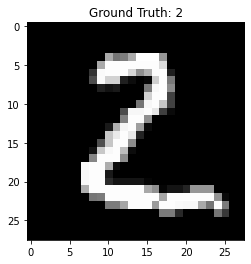

In [26]:
test = example_data[1]
compose(test).shape
plt.imshow(compose(test)[0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[1]))

### Check the prediction :

In [27]:
batch = Variable(compose(test).view(-1, VISIBLE_UNITS))
outputs = Newmodel(batch)
_, prediction = torch.max(outputs.data, 1)
prediction

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([2])

### reconstruct the new img by RBM

In [28]:
recon_data_p1 = rbm.h2v(rbm.v2h(compose(test)[0].view(-1, VISIBLE_UNITS))[0])

### plot the reconstructed new img

Text(0.5, 1.0, 'Ground Truth: 2')

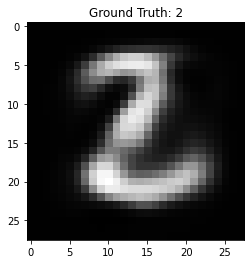

In [29]:
plt.imshow(recon_data_p1.view(recon_data_p1.shape[0],1,28,28)[0][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[1]))